In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, classification_report, roc_auc_score, roc_curve

np.random.seed(1234)

## 1. DATA LOADING 

In [ ]:
df = pd.read_csv('../rotterdam.csv')

## 2. TARGET ENGINEERING

The Survival problem is transformed into a Binary Classification problem: "Will the patient experience recurrence within 5 years (1825 days)?"

The target is defined as:
- 1 = Recurrence observed within 5 years
- 0 = No recurrence observed within 5 years

Then censoring must be handled: patients who did NOT recur but were followed for LESS than 5 years are "censored" early. Their 5-year outcome is unknown. They must be excluded to avoid noise.

In [3]:
CUTOFF_DAYS = 1825 

df['target'] = np.where((df['recur'] == 1) & (df['rtime'] <= CUTOFF_DAYS), 1, 0)

valid_mask = (df['target'] == 1) | (df['rtime'] > CUTOFF_DAYS)
df_clean = df[valid_mask].copy()

print(f"Original shape: {df.shape}")
print(f"Shape after removing early censored data: {df_clean.shape}")
print(f"Class Balance (Recurrence Rate in 5y):\n{df_clean['target'].value_counts(normalize=True)}")

Original shape: (2982, 17)
Shape after removing early censored data: (2355, 17)
Class Balance (Recurrence Rate in 5y):
target
0    0.667091
1    0.332909
Name: proportion, dtype: float64


## 3. PREPROCESSING & FEATURE ENGINEERING

Non-linearity is checked for continuous variables, such as 'nodes' (lymph nodes), which often follows an exponential distribution. In this case, a log-transformed version is more appropriate: log(nodes + 1) to handle zeros.

Additionally, clinical guidelines often bin 'er' and 'pgr' into positive/negative based on a threshold (10 fmol/mg).

In [21]:
df_clean['nodes_log'] = np.log1p(df_clean['nodes'])

num_features = ['age', 'nodes_log']
cat_features = ['grade', 'meno', 'hormon', 'chemo', 'er', 'pgr', 'size'] 

df_clean['er_binary'] = (df_clean['er'] > 10).astype(int)
df_clean['pgr_binary'] = (df_clean['pgr'] > 10).astype(int)
cat_features = ['size', 'grade', 'hormon', 'chemo', 'er_binary', 'pgr_binary']
num_features = ['age', 'nodes_log']

X = df_clean[num_features + cat_features]
y = df_clean['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234, stratify=y
)

## 4. FEATURE SELECTION (LASSO REGULARIZATION)

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
    ])

lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegressionCV(
        cv=5, 
        penalty='l1', 
        solver='liblinear', 
        scoring='roc_auc',
        random_state=1234,
        class_weight='balanced'
    ))
])

print("\n--- Running Lasso Feature Selection ---")
lasso_pipeline.fit(X_train, y_train)

model = lasso_pipeline.named_steps['classifier']
feature_names_out = lasso_pipeline.named_steps['preprocessor'].get_feature_names_out()

coefs = pd.DataFrame({
    'Feature': feature_names_out,
    'Coefficient': model.coef_[0]
})
# Filter selected features (non-zero coefficients)
selected_feats = coefs[coefs['Coefficient'] != 0].sort_values(by='Coefficient', key=abs, ascending=False)
print("\nFeatures selected by Lasso:")
print(selected_feats)


--- Running Lasso Feature Selection ---

Features selected by Lasso:
             Feature  Coefficient
1     num__nodes_log     1.110617
4       cat__grade_3     0.771061
6       cat__chemo_1    -0.725206
2     cat__size_<=20    -0.672492
5      cat__hormon_1    -0.652177
8  cat__pgr_binary_1    -0.486418
3      cat__size_>50     0.361491
0           num__age    -0.277428
7   cat__er_binary_1     0.079051



BEST SUBSET SELECTION - Evaluating All Feature Combinations

Candidate Features (8): ['age', 'nodes_log', 'size', 'grade', 'hormon', 'chemo', 'er_binary', 'pgr_binary']
After encoding: 7 features

Evaluating subsets (this may take a moment)...
Size   Features                                                     CV AUC     AIC        BIC       
------------------------------------------------------------------------------------------
1      age                                                          0.5783       801.9     811.5
1      size_<=20                                                    0.5976       790.4     800.0
1      size_>50                                                     0.5118       807.8     817.4
1      grade_3                                                      0.5763       794.6     804.2
1      er_binary_1                                                  0.5642       799.8     809.5
1      pgr_binary_1                                                 0.5868    

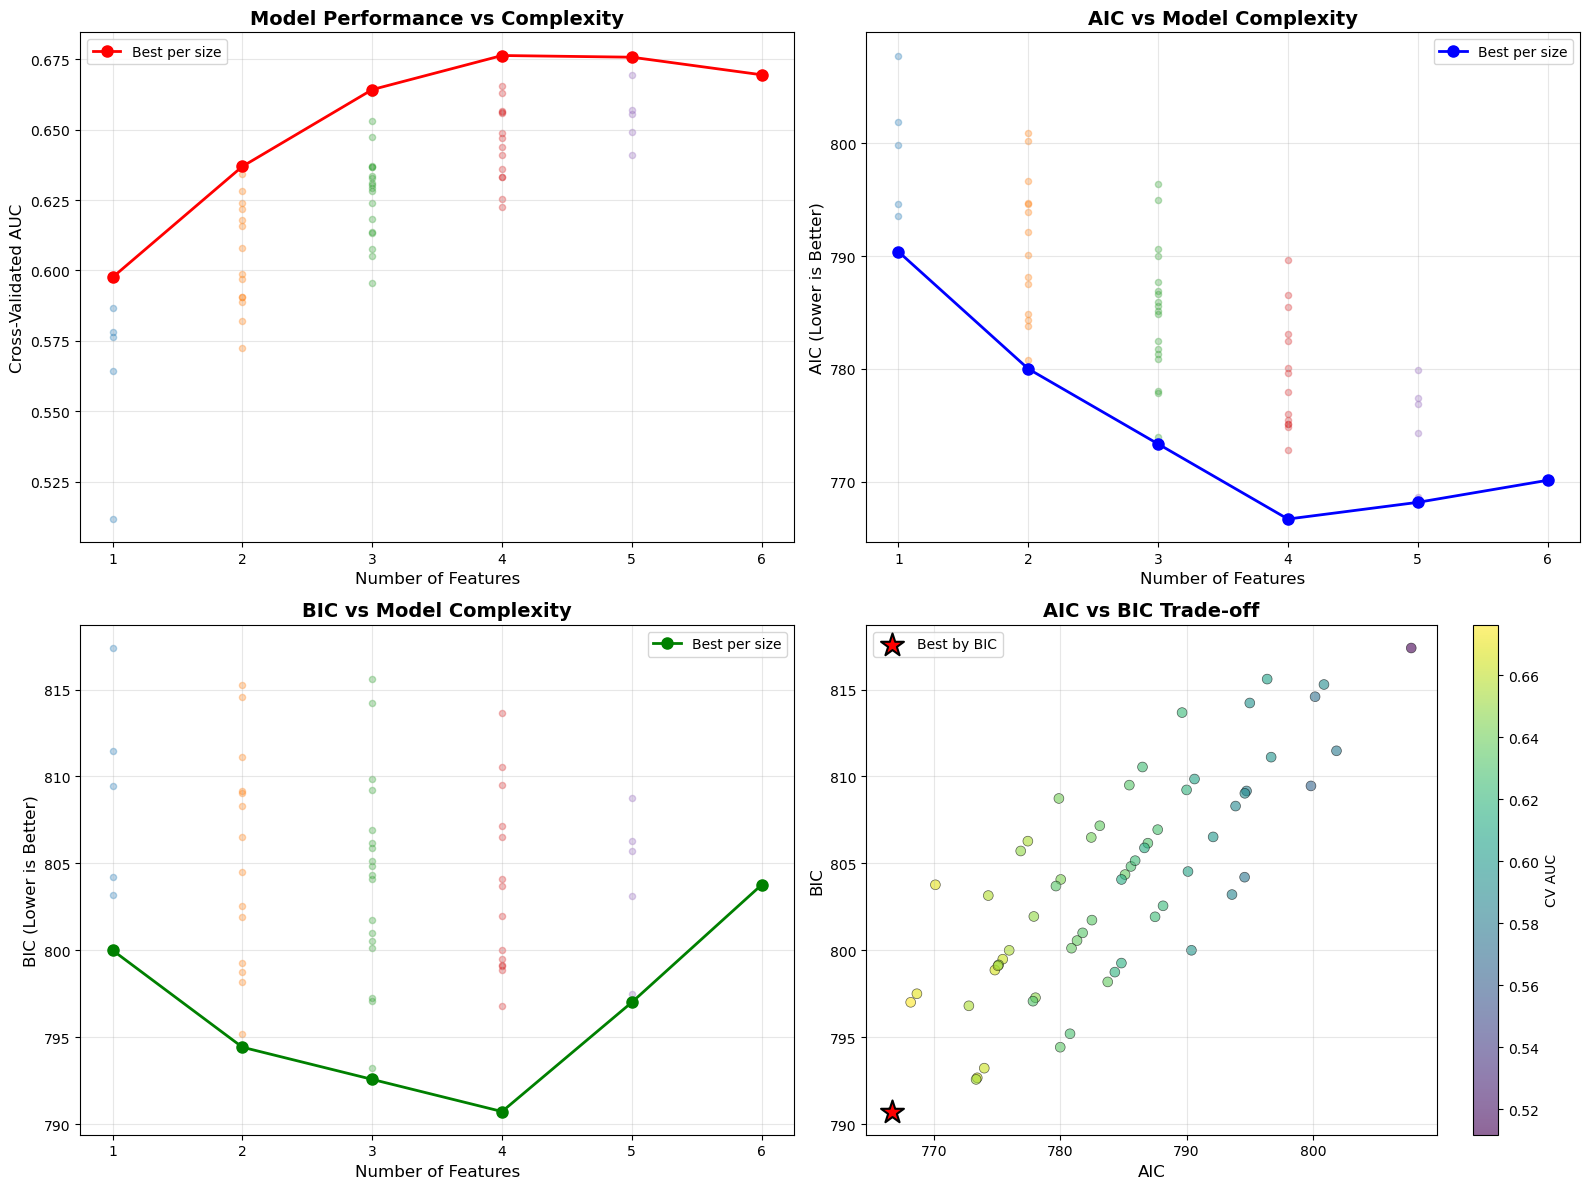


RECOMMENDED MODEL SELECTION

✓ BEST MODEL (by BIC):
  • Features (4): ['age', 'size_<=20', 'grade_3', 'pgr_binary_1']
  • CV AUC: 0.6763
  • AIC: 766.7
  • BIC: 790.7



In [22]:
# =============================================================================
# BEST SUBSET SELECTION - EXHAUSTIVE SEARCH
# =============================================================================
from itertools import combinations
from sklearn.model_selection import cross_val_score

print("\n" + "="*80)
print("BEST SUBSET SELECTION - Evaluating All Feature Combinations")
print("="*80)

# Define candidate features (after one-hot encoding we'll have more)
candidate_features = num_features + cat_features
print(f"\nCandidate Features ({len(candidate_features)}): {candidate_features}")

# Prepare data for subset selection
X_subset = X_train.copy()
y_subset = y_train.copy()

# One-hot encode categorical features
X_subset_encoded = pd.get_dummies(X_subset, columns=cat_features, drop_first=True, dtype=int)
feature_names_encoded = X_subset_encoded.columns.tolist()

print(f"After encoding: {len(feature_names_encoded)} features\n")

# Storage for results
subset_results = []

# Evaluate all possible subsets (from 1 to all features)
print("Evaluating subsets (this may take a moment)...")
print(f"{'Size':<6} {'Features':<60} {'CV AUC':<10} {'AIC':<10} {'BIC':<10}")
print("-" * 90)

# Limit to subsets of reasonable size (1 to min(10, n_features)) for computational efficiency
max_subset_size = min(10, len(feature_names_encoded))

for size in range(1, max_subset_size + 1):
    # Generate all combinations of this size
    for subset in combinations(feature_names_encoded, size):
        subset_list = list(subset)
        
        # Prepare data
        X_temp = X_subset_encoded[subset_list]
        
        # Skip if any feature has no variance
        if (X_temp.std() == 0).any():
            continue
        
        # Standardize for logistic regression
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_temp)
        
        try:
            # Cross-validated AUC
            cv_scores = cross_val_score(
                LogisticRegressionCV(cv=3, scoring='roc_auc', random_state=1234, max_iter=1000),
                X_scaled, y_subset, cv=5, scoring='roc_auc'
            )
            cv_auc = cv_scores.mean()
            
            # Fit full model for AIC/BIC
            X_sm = sm.add_constant(X_temp)
            model_temp = sm.Logit(y_subset, X_sm).fit(disp=0, maxiter=100, warn_convergence=False)
            aic = model_temp.aic
            bic = model_temp.bic
            
            # Store results
            subset_results.append({
                'size': size,
                'features': subset_list,
                'cv_auc': cv_auc,
                'aic': aic,
                'bic': bic,
                'n_params': len(subset_list) + 1  # +1 for intercept
            })
            
            # Print top performers for each size
            if len(subset_results) % 20 == 0 or size <= 3:
                feat_str = ', '.join(subset_list[:3]) + ('...' if len(subset_list) > 3 else '')
                print(f"{size:<6} {feat_str:<60} {cv_auc:.4f}    {aic:>8.1f}  {bic:>8.1f}")
        
        except Exception:
            # Skip models that don't converge
            continue

# Convert to DataFrame for analysis
results_df = pd.DataFrame(subset_results)

print(f"\nTotal models evaluated: {len(results_df)}")

# =============================================================================
# ANALYZE RESULTS
# =============================================================================
print("\n" + "="*80)
print("TOP 10 MODELS BY EACH CRITERION")
print("="*80)

# Top by CV AUC
print("\n--- Top 10 by Cross-Validated AUC ---")
top_cv = results_df.nlargest(10, 'cv_auc')[['size', 'cv_auc', 'aic', 'bic', 'features']]
for idx, row in top_cv.iterrows():
    print(f"Size {row['size']}: AUC={row['cv_auc']:.4f}, AIC={row['aic']:.1f}, BIC={row['bic']:.1f}")
    print(f"  Features: {row['features'][:5]}" + ('...' if len(row['features']) > 5 else ''))

# Top by AIC
print("\n--- Top 10 by AIC (Lower is Better) ---")
top_aic = results_df.nsmallest(10, 'aic')[['size', 'cv_auc', 'aic', 'bic', 'features']]
for idx, row in top_aic.iterrows():
    print(f"Size {row['size']}: AUC={row['cv_auc']:.4f}, AIC={row['aic']:.1f}, BIC={row['bic']:.1f}")
    print(f"  Features: {row['features'][:5]}" + ('...' if len(row['features']) > 5 else ''))

# Top by BIC (more parsimonious)
print("\n--- Top 10 by BIC (Lower is Better, More Parsimonious) ---")
top_bic = results_df.nsmallest(10, 'bic')[['size', 'cv_auc', 'aic', 'bic', 'features']]
for idx, row in top_bic.iterrows():
    print(f"Size {row['size']}: AUC={row['cv_auc']:.4f}, AIC={row['aic']:.1f}, BIC={row['bic']:.1f}")
    print(f"  Features: {row['features'][:5]}" + ('...' if len(row['features']) > 5 else ''))

# =============================================================================
# VISUALIZE RESULTS
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. AUC vs Model Size
ax1 = axes[0, 0]
for size in results_df['size'].unique():
    subset_size = results_df[results_df['size'] == size]
    ax1.scatter([size] * len(subset_size), subset_size['cv_auc'], alpha=0.3, s=20)

# Highlight best per size
best_per_size = results_df.loc[results_df.groupby('size')['cv_auc'].idxmax()]
ax1.plot(best_per_size['size'], best_per_size['cv_auc'], 'r-o', linewidth=2, 
         markersize=8, label='Best per size')
ax1.set_xlabel('Number of Features', fontsize=12)
ax1.set_ylabel('Cross-Validated AUC', fontsize=12)
ax1.set_title('Model Performance vs Complexity', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. AIC vs Model Size
ax2 = axes[0, 1]
for size in results_df['size'].unique():
    subset_size = results_df[results_df['size'] == size]
    ax2.scatter([size] * len(subset_size), subset_size['aic'], alpha=0.3, s=20)

best_per_size_aic = results_df.loc[results_df.groupby('size')['aic'].idxmin()]
ax2.plot(best_per_size_aic['size'], best_per_size_aic['aic'], 'b-o', linewidth=2,
         markersize=8, label='Best per size')
ax2.set_xlabel('Number of Features', fontsize=12)
ax2.set_ylabel('AIC (Lower is Better)', fontsize=12)
ax2.set_title('AIC vs Model Complexity', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. BIC vs Model Size
ax3 = axes[1, 0]
for size in results_df['size'].unique():
    subset_size = results_df[results_df['size'] == size]
    ax3.scatter([size] * len(subset_size), subset_size['bic'], alpha=0.3, s=20)

best_per_size_bic = results_df.loc[results_df.groupby('size')['bic'].idxmin()]
ax3.plot(best_per_size_bic['size'], best_per_size_bic['bic'], 'g-o', linewidth=2,
         markersize=8, label='Best per size')
ax3.set_xlabel('Number of Features', fontsize=12)
ax3.set_ylabel('BIC (Lower is Better)', fontsize=12)
ax3.set_title('BIC vs Model Complexity', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. AIC vs BIC Trade-off
ax4 = axes[1, 1]
scatter = ax4.scatter(results_df['aic'], results_df['bic'], 
                      c=results_df['cv_auc'], cmap='viridis', 
                      s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('CV AUC', fontsize=10)

# Mark best overall model (by BIC)
best_overall = results_df.loc[results_df['bic'].idxmin()]
ax4.scatter(best_overall['aic'], best_overall['bic'], 
           color='red', s=300, marker='*', 
           edgecolors='black', linewidth=1.5, label='Best by BIC')
ax4.set_xlabel('AIC', fontsize=12)
ax4.set_ylabel('BIC', fontsize=12)
ax4.set_title('AIC vs BIC Trade-off', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# RECOMMENDED MODEL
# =============================================================================
print("\n" + "="*80)
print("RECOMMENDED MODEL SELECTION")
print("="*80)

# Best by BIC (balance of fit and parsimony)
best_model = results_df.loc[results_df['bic'].idxmin()]
print(f"\n✓ BEST MODEL (by BIC):")
print(f"  • Features ({best_model['size']}): {best_model['features']}")
print(f"  • CV AUC: {best_model['cv_auc']:.4f}")
print(f"  • AIC: {best_model['aic']:.1f}")
print(f"  • BIC: {best_model['bic']:.1f}")

# Alternative: Best by AUC if significantly better
best_auc_model = results_df.loc[results_df['cv_auc'].idxmax()]
if best_auc_model['cv_auc'] - best_model['cv_auc'] > 0.02:  # 2% improvement threshold
    print(f"\n⚠ ALTERNATIVE: Best by CV AUC (significantly better):")
    print(f"  • Features ({best_auc_model['size']}): {best_auc_model['features']}")
    print(f"  • CV AUC: {best_auc_model['cv_auc']:.4f}")
    print(f"  • AIC: {best_auc_model['aic']:.1f}")
    print(f"  • BIC: {best_auc_model['bic']:.1f}")

print("\n" + "="*80)


REFITTING MODEL WITH OPTIMAL FEATURE SET

Selected Features (4):
  1. age
  2. size_<=20
  3. grade_3
  4. pgr_binary_1

--------------------------------------------------------------------------------
Training Final Model...
--------------------------------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  904
Model:                          Logit   Df Residuals:                      899
Method:                           MLE   Df Model:                            4
Date:                Mon, 12 Jan 2026   Pseudo R-squ.:                 0.06115
Time:                        10:43:23   Log-Likelihood:                -378.34
converged:                       True   LL-Null:                       -402.99
Covariance Type:            nonrobust   LLR p-value:                 5.082e-10
                   coef    std err          z      P>|z|    

c:\Users\ricca\miniconda3\envs\rick\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


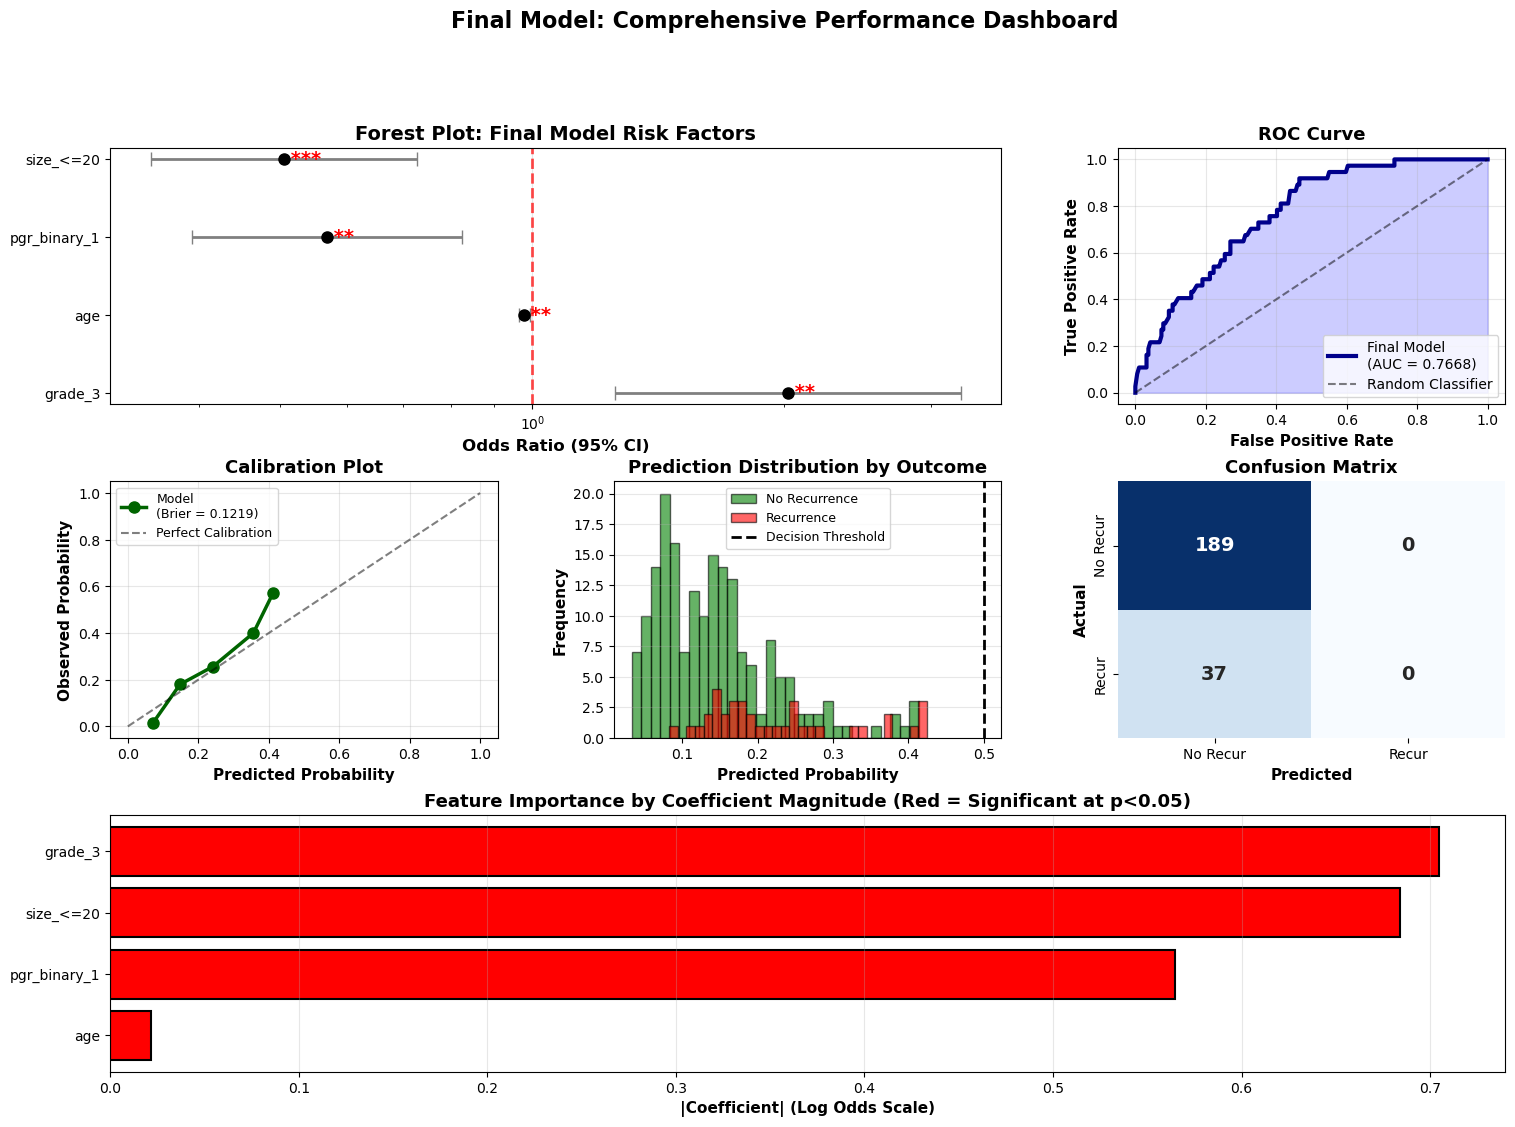


✓ FINAL MODEL SUCCESSFULLY FITTED AND VALIDATED


In [23]:
# =============================================================================
# REFIT FINAL MODEL WITH BEST SUBSET FEATURES
# =============================================================================

print("\n" + "="*80)
print("REFITTING MODEL WITH OPTIMAL FEATURE SET")
print("="*80)

# Extract the best model features from best subset selection
best_features = best_model['features']
print(f"\nSelected Features ({len(best_features)}):")
for i, feat in enumerate(best_features, 1):
    print(f"  {i}. {feat}")

# =============================================================================
# TRAIN SET: Fit Model
# =============================================================================
# Prepare training data with selected features
X_train_optimal = X_train.copy()
X_train_optimal = pd.get_dummies(X_train_optimal, columns=cat_features, drop_first=True, dtype=int)

# Select only the best subset features
X_train_final = X_train_optimal[best_features].copy()
X_train_final = sm.add_constant(X_train_final)

# Fit the model
print("\n" + "-"*80)
print("Training Final Model...")
print("-"*80)
model_final = sm.Logit(y_train, X_train_final).fit(disp=0)
print(model_final.summary())

# =============================================================================
# TEST SET: Prepare and Predict
# =============================================================================
X_test_optimal = X_test.copy()
X_test_optimal = pd.get_dummies(X_test_optimal, columns=cat_features, drop_first=True, dtype=int)

# Align test set with training features
X_test_final = X_test_optimal.reindex(columns=best_features, fill_value=0)
X_test_final = sm.add_constant(X_test_final)

# Predictions
y_prob_final = model_final.predict(X_test_final)
y_pred_final = (y_prob_final > 0.5).astype(int)

# =============================================================================
# PERFORMANCE METRICS
# =============================================================================
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix)

auc_final = roc_auc_score(y_test, y_prob_final)
brier_final = brier_score_loss(y_test, y_prob_final)
fpr_final, tpr_final, thresholds = roc_curve(y_test, y_prob_final)

print("\n" + "="*80)
print("FINAL MODEL PERFORMANCE")
print("="*80)

# Classification metrics
accuracy = accuracy_score(y_test, y_pred_final)
precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)

print(f"\nTest Set Performance:")
print(f"  • AUC-ROC:        {auc_final:.4f}")
print(f"  • Brier Score:    {brier_final:.4f} (lower is better)")
print(f"  • Accuracy:       {accuracy:.4f}")
print(f"  • Precision:      {precision:.4f}")
print(f"  • Recall:         {recall:.4f}")
print(f"  • F1-Score:       {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
print(f"\nConfusion Matrix:")
print(f"  True Neg:  {cm[0,0]:>4}  |  False Pos: {cm[0,1]:>4}")
print(f"  False Neg: {cm[1,0]:>4}  |  True Pos:  {cm[1,1]:>4}")

# Model fit statistics
print(f"\nModel Fit Statistics:")
print(f"  • AIC:            {model_final.aic:.1f}")
print(f"  • BIC:            {model_final.bic:.1f}")
print(f"  • Log-Likelihood: {model_final.llf:.1f}")
print(f"  • Pseudo R²:      {model_final.prsquared:.4f}")

# =============================================================================
# ODDS RATIOS & INTERPRETATION
# =============================================================================
print("\n" + "="*80)
print("ODDS RATIOS & CLINICAL INTERPRETATION")
print("="*80)

params = model_final.params
conf_int = model_final.conf_int()
pvalues = model_final.pvalues

# Create odds ratio table
or_table = pd.DataFrame({
    'Coefficient': params,
    'OR': np.exp(params),
    'Lower_CI': np.exp(conf_int[0]),
    'Upper_CI': np.exp(conf_int[1]),
    'P-Value': pvalues
}).drop('const', errors='ignore')

or_table = or_table.sort_values('OR', ascending=False)

print("\nOdds Ratios (Sorted by Effect Size):")
print(or_table.round(4))

# Highlight significant predictors
sig_predictors = or_table[or_table['P-Value'] < 0.05]
print(f"\n✓ Significant Predictors (p < 0.05): {len(sig_predictors)}/{len(or_table)}")
print("\nSignificant Risk Factors:")
for idx, row in sig_predictors.iterrows():
    effect = "↑ INCREASED" if row['OR'] > 1 else "↓ DECREASED"
    pct_change = abs((row['OR'] - 1) * 100)
    print(f"  • {idx:20s} OR={row['OR']:.3f} (95% CI: {row['Lower_CI']:.3f}-{row['Upper_CI']:.3f}) {effect} risk by {pct_change:.1f}%")

# =============================================================================
# VISUALIZATIONS
# =============================================================================
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Forest Plot
ax1 = fig.add_subplot(gs[0, :2])
y_pos = np.arange(len(or_table))

ax1.errorbar(or_table['OR'], y_pos, 
            xerr=[or_table['OR']-or_table['Lower_CI'], or_table['Upper_CI']-or_table['OR']],
            fmt='o', color='black', ecolor='gray', capsize=5, markersize=8, linewidth=2)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(or_table.index, fontsize=10)
ax1.axvline(x=1, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax1.set_xlabel('Odds Ratio (95% CI)', fontsize=12, fontweight='bold')
ax1.set_title('Forest Plot: Final Model Risk Factors', fontsize=14, fontweight='bold')
ax1.set_xscale('log')
ax1.grid(axis='x', alpha=0.3)

# Add significance stars
for i, (idx, row) in enumerate(or_table.iterrows()):
    if row['P-Value'] < 0.001:
        ax1.text(row['OR'], i, ' ***', fontsize=14, va='center', color='red', fontweight='bold')
    elif row['P-Value'] < 0.01:
        ax1.text(row['OR'], i, ' **', fontsize=14, va='center', color='red', fontweight='bold')
    elif row['P-Value'] < 0.05:
        ax1.text(row['OR'], i, ' *', fontsize=14, va='center', color='red', fontweight='bold')

# 2. ROC Curve
ax2 = fig.add_subplot(gs[0, 2])
ax2.plot(fpr_final, tpr_final, linewidth=3, label=f'Final Model\n(AUC = {auc_final:.4f})', color='darkblue')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier', alpha=0.5)
ax2.fill_between(fpr_final, tpr_final, alpha=0.2, color='blue')
ax2.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax2.set_title('ROC Curve', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10, loc='lower right')
ax2.grid(alpha=0.3)

# 3. Calibration Curve
ax3 = fig.add_subplot(gs[1, 0])
prob_true, prob_pred = calibration_curve(y_test, y_prob_final, n_bins=10)
ax3.plot(prob_pred, prob_true, marker='o', linewidth=2.5, markersize=8, 
         label=f'Model\n(Brier = {brier_final:.4f})', color='darkgreen')
ax3.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration', alpha=0.5)
ax3.set_xlabel('Predicted Probability', fontsize=11, fontweight='bold')
ax3.set_ylabel('Observed Probability', fontsize=11, fontweight='bold')
ax3.set_title('Calibration Plot', fontsize=13, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3)

# 4. Predicted Probability Distribution
ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(y_prob_final[y_test == 0], bins=30, alpha=0.6, label='No Recurrence', color='green', edgecolor='black')
ax4.hist(y_prob_final[y_test == 1], bins=30, alpha=0.6, label='Recurrence', color='red', edgecolor='black')
ax4.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
ax4.set_xlabel('Predicted Probability', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax4.set_title('Prediction Distribution by Outcome', fontsize=13, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(axis='y', alpha=0.3)

# 5. Confusion Matrix Heatmap
ax5 = fig.add_subplot(gs[1, 2])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax5,
            xticklabels=['No Recur', 'Recur'], yticklabels=['No Recur', 'Recur'],
            annot_kws={'size': 14, 'weight': 'bold'})
ax5.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax5.set_ylabel('Actual', fontsize=11, fontweight='bold')
ax5.set_title('Confusion Matrix', fontsize=13, fontweight='bold')

# 6. Feature Importance (Coefficient Magnitude)
ax6 = fig.add_subplot(gs[2, :])
coef_importance = or_table['Coefficient'].abs().sort_values(ascending=True)
colors_imp = ['red' if or_table.loc[idx, 'P-Value'] < 0.05 else 'gray' for idx in coef_importance.index]
ax6.barh(range(len(coef_importance)), coef_importance.values, color=colors_imp, edgecolor='black', linewidth=1.5)
ax6.set_yticks(range(len(coef_importance)))
ax6.set_yticklabels(coef_importance.index, fontsize=10)
ax6.set_xlabel('|Coefficient| (Log Odds Scale)', fontsize=11, fontweight='bold')
ax6.set_title('Feature Importance by Coefficient Magnitude (Red = Significant at p<0.05)', 
              fontsize=13, fontweight='bold')
ax6.grid(axis='x', alpha=0.3)

plt.suptitle('Final Model: Comprehensive Performance Dashboard', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n" + "="*80)
print("✓ FINAL MODEL SUCCESSFULLY FITTED AND VALIDATED")
print("="*80)

## 4B. REFIT FINAL MODEL WITH SELECTED FEATURES

Now we refit the model using ONLY the features selected by best subset selection for optimal performance and interpretability.

## 5. FINAL MODEL & STATISTICAL INFERENCE
The model is refitted using ONLY selected features in statsmodels to get valid P-values and Confidence Intervals for the report.

In [ ]:
X_train_sm = X_train.copy()
X_test_sm = X_test.copy()

X_train_sm = pd.get_dummies(X_train_sm, columns=cat_features, drop_first=True, dtype=int)
X_test_sm = pd.get_dummies(X_test_sm, columns=cat_features, drop_first=True, dtype=int)

X_train_sm, X_test_sm = X_train_sm.align(X_test_sm, join='left', axis=1, fill_value=0)

X_train_sm = sm.add_constant(X_train_sm)
X_test_sm = sm.add_constant(X_test_sm)

logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

print("\n--- Final Model Summary (Statsmodels) ---")
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.494832
         Iterations 6

--- Final Model Summary (Statsmodels) ---
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 1884
Model:                          Logit   Df Residuals:                     1873
Method:                           MLE   Df Model:                           10
Date:                Sun, 11 Jan 2026   Pseudo R-squ.:                  0.2221
Time:                        19:25:00   Log-Likelihood:                -932.26
converged:                       True   LL-Null:                       -1198.5
Covariance Type:            nonrobust   LLR p-value:                5.046e-108
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.3595      0.395     -0.910      0.363     

## 6. ODDS RATIOS & FOREST PLOT


--- Odds Ratios (for Report Table) ---
               2.5%  97.5%  Log Odds  P-Value
age           0.961  0.992     0.976    0.003
nodes_log     2.711  3.652     3.147    0.000
size_<=20     0.411  0.672     0.525    0.000
size_>50      0.959  2.089     1.415    0.080
grade_3       1.585  2.792     2.104    0.000
meno_1        0.737  1.665     1.108    0.621
hormon_1      0.366  0.791     0.538    0.002
chemo_1       0.359  0.696     0.500    0.000
er_binary_1   0.762  1.447     1.050    0.767
pgr_binary_1  0.482  0.873     0.649    0.004


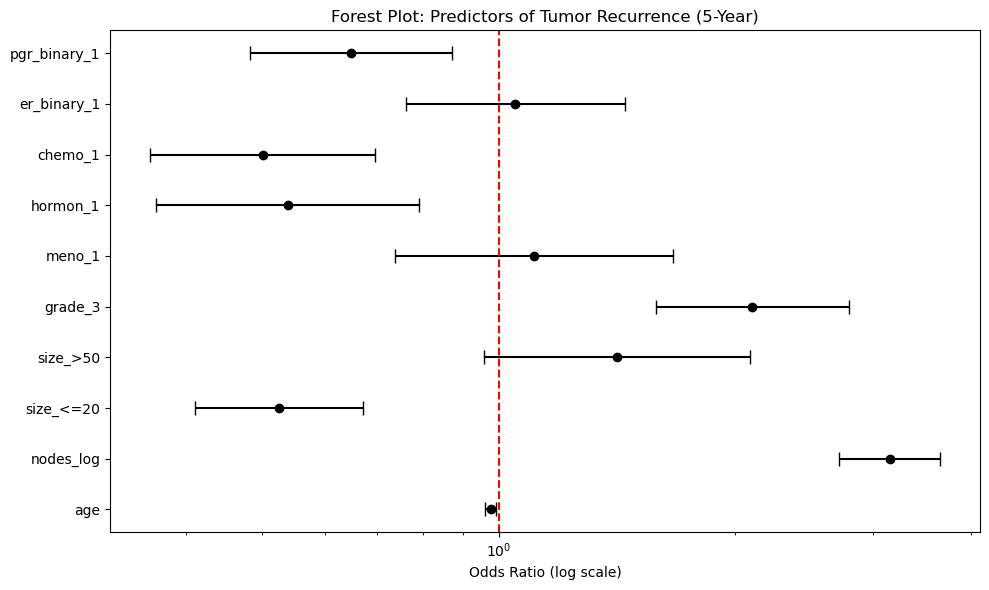

In [ ]:
params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Log Odds']
conf_or = np.exp(conf)
conf_or['P-Value'] = result.pvalues
conf_or = conf_or.drop('const', errors='ignore')

print("\n--- Odds Ratios (for Report Table) ---")
print(conf_or.round(3))

plt.figure(figsize=(10, 6))
plt.errorbar(conf_or['Log Odds'], conf_or.index, 
             xerr=[conf_or['Log Odds'] - conf_or['2.5%'], conf_or['97.5%'] - conf_or['Log Odds']], 
             fmt='o', color='black', capsize=5)
plt.axvline(x=1, color='red', linestyle='--')
plt.title('Forest Plot: Predictors of Tumor Recurrence (5-Year)')
plt.xlabel('Odds Ratio (log scale)')
plt.xscale('log')
plt.tight_layout()
plt.show()

## 7. PREDICTIVE PERFORMANCE (ROC & CALIBRATION)

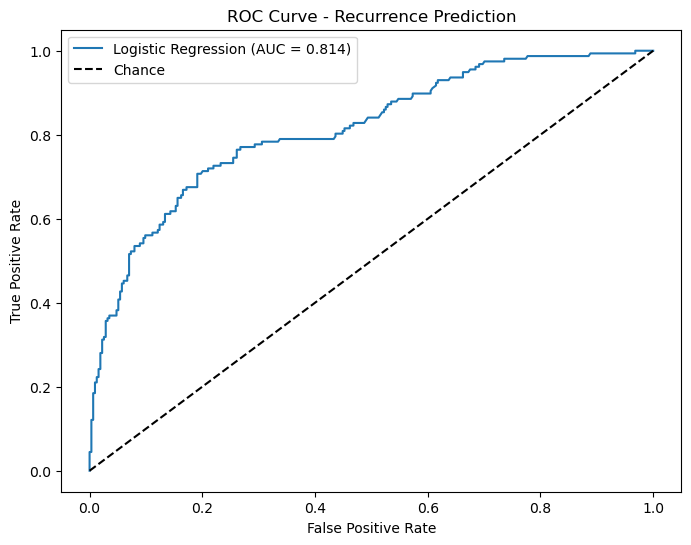

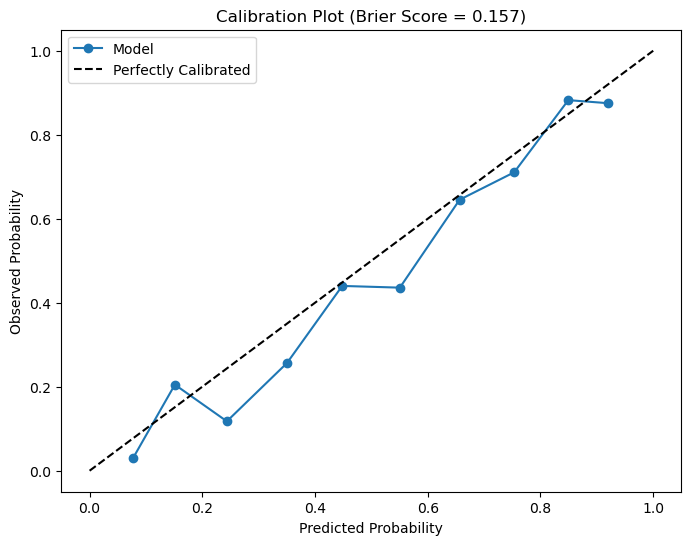


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       314
           1       0.67      0.64      0.66       157

    accuracy                           0.78       471
   macro avg       0.75      0.74      0.75       471
weighted avg       0.77      0.78      0.78       471



In [ ]:
y_prob = result.predict(X_test_sm)
y_pred = (y_prob > 0.5).astype(int)

auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Recurrence Prediction")
plt.legend()
plt.show()

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
brier = brier_score_loss(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
plt.title(f'Calibration Plot (Brier Score = {brier:.3f})')
plt.legend()
plt.show()

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

Subgroup        | N (Patients) | Recurrence Events  | Model Status
---------------------------------------------------------------------------
0 Nodes         | 1130         | 185                | CONVERGED (Multivariable)
1-3 Nodes       | 585          | 172                | CONVERGED (Multivariable)
4-9 Nodes       | 397          | 234                | CONVERGED (Multivariable)
10+ Nodes       | 243          | 193                | CONVERGED (Multivariable)


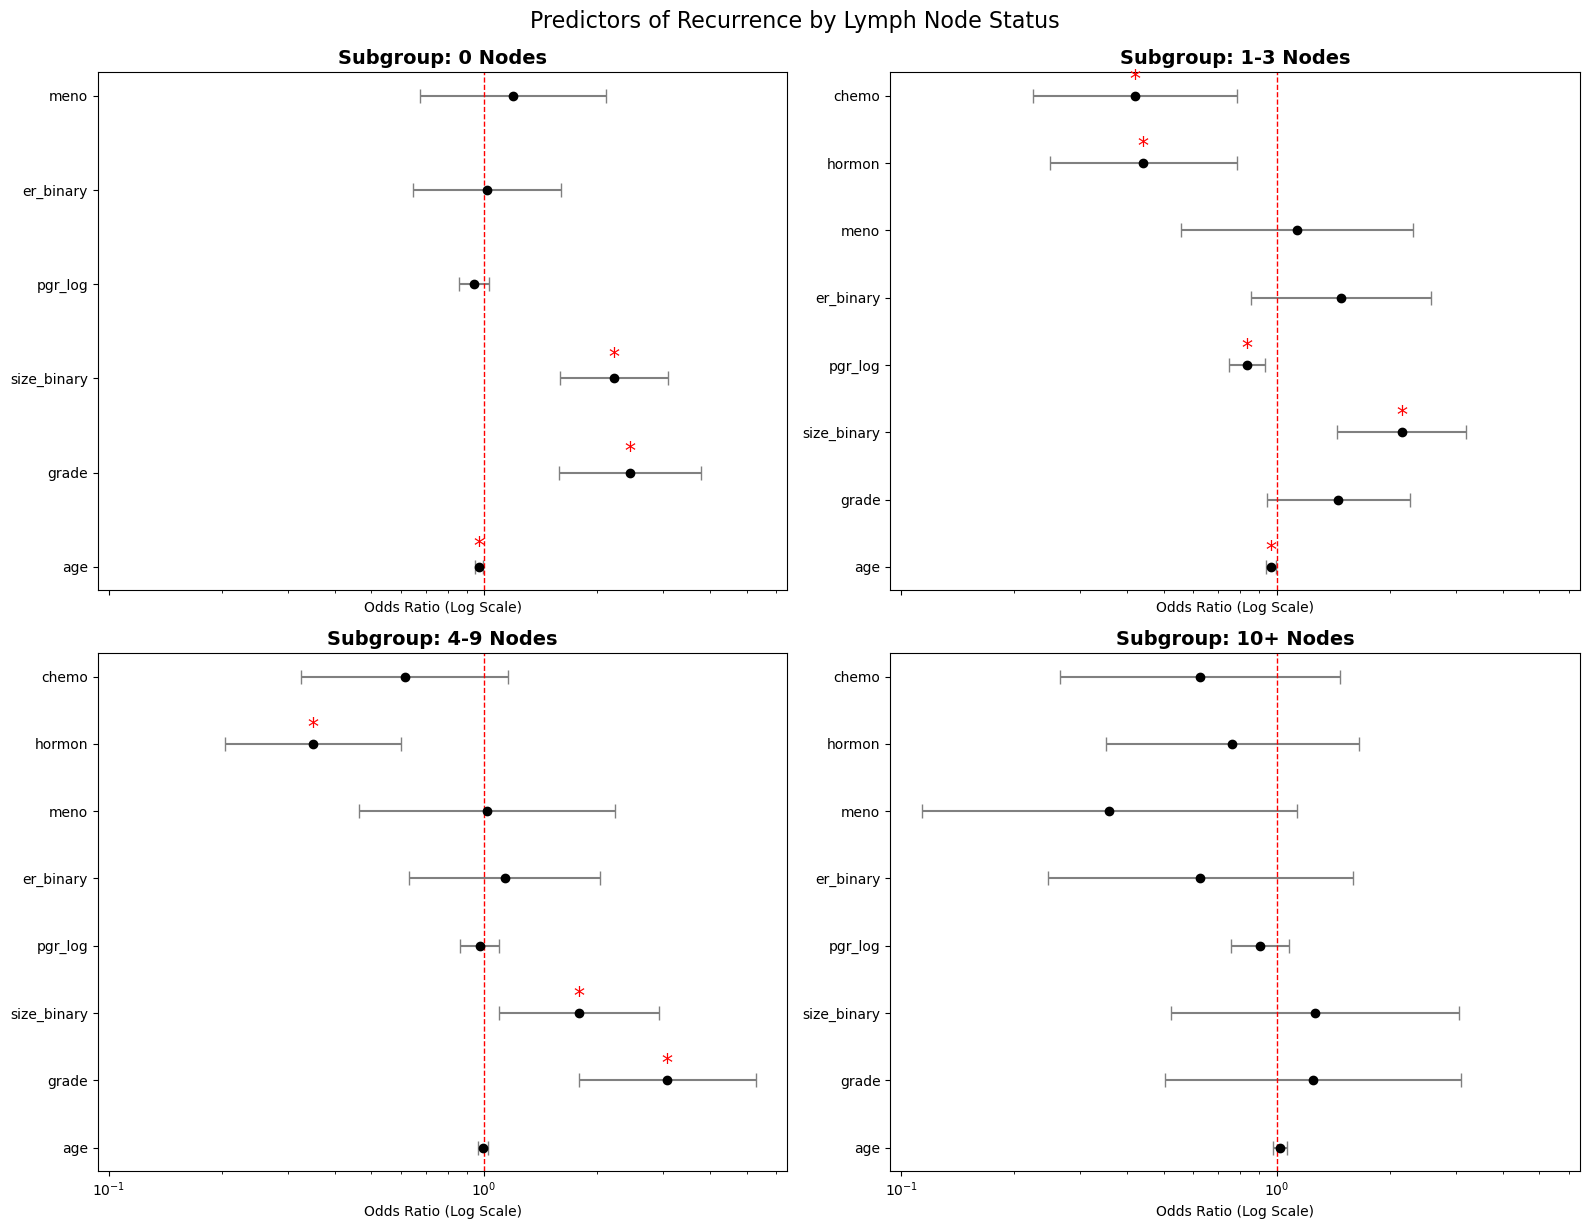

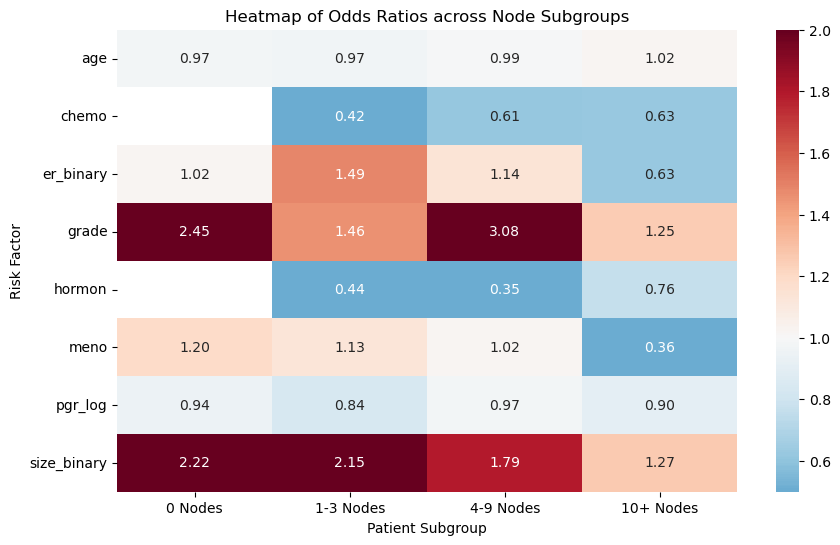

In [ ]:
# =============================================================================
# ROBUST SUBGROUP ANALYSIS: RISK FACTORS BY LYMPH NODE STATUS
# =============================================================================
# Goal: Determine if risk factors (Age, Grade, Size, etc.) influence recurrence 
# differently depending on the number of positive lymph nodes (0, 1-3, 4-9, 10+).

import matplotlib.patches as mpatches

# 1. Define Subgroups (Clinical Staging Categories)
# -------------------------------------------------
# We bin 'nodes' into: 0 (Node Negative), 1-3, 4-9, and 10+
df_clean['node_category'] = pd.cut(
    df_clean['nodes'], 
    bins=[-1, 0, 3, 9, 100], 
    labels=['0 Nodes', '1-3 Nodes', '4-9 Nodes', '10+ Nodes']
)

# 2. Define Variables for Analysis
# --------------------------------
# Note: We EXCLUDE 'nodes' from predictors because it is the stratification variable.
# We ensure continuous vars are scaled or logged if necessary (done in previous steps).
predictors_subgroup = [
    'age',          # Continuous
    'grade',        # Categorical (Ordinal-like)
    'size_binary',  # 0=Small (<=20), 1=Large (>20) - Ensure this column exists from prev steps
    'pgr_log',      # Log-transformed Progesterone Receptor
    'er_binary',    # Estrogen Receptor Status
    'meno',         # Menopausal Status
    'hormon',       # Hormonal Therapy
    'chemo'         # Chemotherapy
]

# Ensure binary/derived columns exist (if not created in previous cells)
if 'size_binary' not in df_clean.columns:
    df_clean['size_binary'] = df_clean['size'].apply(lambda x: 0 if x == '<=20' else 1)
if 'pgr_log' not in df_clean.columns:
    df_clean['pgr_log'] = np.log1p(df_clean['pgr'])

# 3. Fit Models & Store Results
# -----------------------------
subgroup_results = {}
categories = ['0 Nodes', '1-3 Nodes', '4-9 Nodes', '10+ Nodes']

# Require a minimum number of events and non-events per subgroup to attempt modeling
min_events = 5  # more meaningful than a fixed N threshold

print(f"{'Subgroup':<15} | {'N (Patients)':<12} | {'Recurrence Events':<18} | {'Model Status'}")
print("-" * 75)

for cat in categories:
    # Filter Data
    subset = df_clean[df_clean['node_category'] == cat].copy()
    
    # Prepare y and quick counts
    y_sub = subset['target']
    n_patients = len(subset)
    n_events = int(y_sub.sum())
    n_nonevents = int(n_patients - n_events)

    # Event-based robustness check
    if (n_events < min_events) or (n_nonevents < min_events):
        print(f"{cat:<15} | {n_patients:<12} | {n_events:<18} | SKIPPED (Too few events/non-events)")
        continue

    # Prepare X: drop predictors with no variability within subgroup
    X_sub = subset[predictors_subgroup].copy()
    constant_cols = [c for c in X_sub.columns if X_sub[c].nunique() <= 1]
    if constant_cols:
        X_sub.drop(columns=constant_cols, inplace=True)
    
    # If all predictors were constant, skip subgroup
    if X_sub.shape[1] == 0:
        print(f"{cat:<15} | {n_patients:<12} | {n_events:<18} | SKIPPED (All predictors constant)")
        continue

    # Add Intercept
    X_multi = sm.add_constant(X_sub, has_constant='add')

    try:
        # Try multivariable Logit model (Statsmodels for Inference)
        model_sub = sm.Logit(y_sub, X_multi).fit(disp=0)
        
        # Store Odds Ratios and CIs (on OR scale)
        params = model_sub.params
        conf = model_sub.conf_int()
        conf.columns = ['Lower CI', 'Upper CI']
        conf = conf.apply(np.exp)  # exponentiate CI bounds to OR scale
        or_series = np.exp(params)  # odds ratios
        conf['OR'] = or_series
        conf['pvalue'] = model_sub.pvalues
        
        # Drop intercept for plotting
        subgroup_results[cat] = conf.drop('const', errors='ignore')
        
        print(f"{cat:<15} | {n_patients:<12} | {n_events:<18} | CONVERGED (Multivariable)")
        
    except Exception as e:
        # Fallback: fit UNIVARIATE models per predictor to avoid separation/collinearity issues
        rows = []
        for col in X_sub.columns:
            try:
                Xi = sm.add_constant(X_sub[[col]], has_constant='add')
                m_uni = sm.Logit(y_sub, Xi).fit(disp=0)
                p = m_uni.params[col]
                ci = m_uni.conf_int()
                lower = np.exp(ci.loc[col, 0])
                upper = np.exp(ci.loc[col, 1])
                rows.append({
                    'variable': col,
                    'OR': float(np.exp(p)),
                    'Lower CI': float(lower),
                    'Upper CI': float(upper),
                    'pvalue': float(m_uni.pvalues[col])
                })
            except Exception:
                # Skip predictors that still fail in univariate model
                continue
        if rows:
            df_uni = pd.DataFrame(rows).set_index('variable')
            subgroup_results[cat] = df_uni
            print(f"{cat:<15} | {n_patients:<12} | {n_events:<18} | UNIVARIATE FALLBACK")
        else:
            print(f"{cat:<15} | {n_patients:<12} | {n_events:<18} | FAILED ({str(e)})")

# 4. Visualization 1: 2x2 Grid of Forest Plots
# --------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)
axes = axes.flatten()

for i, cat in enumerate(categories):
    ax = axes[i]
    
    if cat in subgroup_results:
        data = subgroup_results[cat]
        
        # Error bar plot
        # We plot ORs on a log scale (symmetric in log-space)
        y_pos = np.arange(len(data))
        # Non-negative asymmetric errors on OR scale
        left_err = (data['OR'] - data['Lower CI']).clip(lower=0)
        right_err = (data['Upper CI'] - data['OR']).clip(lower=0)
        ax.errorbar(data['OR'], y_pos, 
                    xerr=[left_err.values, right_err.values], 
                    fmt='o', color='black', ecolor='gray', capsize=5)
        
        # Styling
        ax.set_yticks(y_pos)
        ax.set_yticklabels(data.index)
        ax.axvline(x=1, color='red', linestyle='--', linewidth=1)
        ax.set_title(f"Subgroup: {cat}", fontsize=14, fontweight='bold')
        ax.set_xscale('log') # Log scale is standard for OR plots
        ax.set_xlabel("Odds Ratio (Log Scale)")
        
        # Highlight significant variables
        for idx, (name, row) in enumerate(data.iterrows()):
            if row['pvalue'] < 0.05:
                ax.text(row['OR'], idx + 0.15, '*', color='red', fontsize=16, ha='center')

    else:
        ax.text(0.5, 0.5, "Insufficient Data / No Model", ha='center', va='center')

plt.tight_layout()
plt.suptitle("Predictors of Recurrence by Lymph Node Status", y=1.02, fontsize=16)
plt.show()

# 5. Visualization 2: Comparative Heatmap (High-level Summary)
# ------------------------------------------------------------
# Combine ORs into a single DataFrame for heatmap
heatmap_data = pd.DataFrame({cat: res['OR'] for cat, res in subgroup_results.items()})

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="RdBu_r", center=1, vmin=0.5, vmax=2.0)
plt.title("Heatmap of Odds Ratios across Node Subgroups")
plt.ylabel("Risk Factor")
plt.xlabel("Patient Subgroup")
plt.show()

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, brier_score_loss

# 1. DATA PREPARATION ---------------------------------------------------------
# Load data (assuming the file is in the working directory)
df = pd.read_csv('rotterdam.csv')

# --- Filter for Node-Negative (N0) Patients ---
# This implies 'nodes' is 0. 
df_n0 = df[df['nodes'] == 0].copy()

print(f"Total N0 patients: {len(df_n0)}")

# --- Target Engineering (Binary Recurrence) ---
# Censoring handling: 
# 1 = Recurred within 5 years
# 0 = Did not recur within 5 years (must have >5 years follow-up to be sure)
CUTOFF_DAYS = 1825 
df_n0['target'] = np.where((df_n0['recur'] == 1) & (df_n0['rtime'] <= CUTOFF_DAYS), 1, 0)

# Remove patients censored early (< 5 years) who did NOT recur
valid_mask = (df_n0['target'] == 1) | (df_n0['rtime'] > CUTOFF_DAYS)
df_clean = df_n0[valid_mask].copy()

print(f"N0 patients valid for 5y analysis: {len(df_clean)}")
print(f"Recurrence Rate in N0: {df_clean['target'].mean():.2%}")

# 2. FEATURE ENGINEERING (Interactions for Research Question) -----------------

# Ensure categorical variables are proper types
# Grade is often ordinal, but treating as categorical allows non-linear effects
df_clean['grade'] = df_clean['grade'].astype(str)

# Log transform skewed continuous variables if necessary (ER/PGR often skewed)
# Adding +1 to avoid log(0)
df_clean['er_log'] = np.log1p(df_clean['er'])
df_clean['pgr_log'] = np.log1p(df_clean['pgr'])

# --- Manual Interaction Creation ---
# We create these manually so Lasso can select them specifically
# 1. Interaction: Hormone Therapy * Age
df_clean['hormon_x_age'] = df_clean['hormon'] * df_clean['age']

# 2. Interaction: Quantitative Receptors * Grade
# Since grade is categorical (2 vs 3), we do this via dummy encoding logic later
# or simplified here:
# Let's create numeric grade for interaction approximation or dummy-based interaction
# For simplicity in selection, let's treat grade as numeric (1,2,3) for the interaction term
df_clean['grade_num'] = df_clean['grade'].astype(float)
df_clean['er_x_grade'] = df_clean['er_log'] * df_clean['grade_num']
df_clean['pgr_x_grade'] = df_clean['pgr_log'] * df_clean['grade_num']

# List of candidates
num_cols = ['age', 'er_log', 'pgr_log', 
            'hormon_x_age', 'er_x_grade', 'pgr_x_grade']
cat_cols = ['grade', 'meno', 'hormon', 'chemo', 'size']

# 3. PREPROCESSING -----------------------------------------------------------
X = df_clean[num_cols + cat_cols]
y = df_clean['target']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234, stratify=y
)

# Pipeline for scaling/encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ])

# 4. STEP 1: LASSO FEATURE SELECTION -----------------------------------------
# We use Lasso to shrink coefficients of irrelevant interactions to zero
print("\n--- Running Lasso for Initial Feature Screening ---")

lasso_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegressionCV(
        cv=5, 
        penalty='l1', 
        solver='liblinear', 
        scoring='roc_auc', 
        max_iter=5000,
        random_state=1234
    ))
])

lasso_model.fit(X_train, y_train)

# Extract selected features
coefs = lasso_model.named_steps['classifier'].coef_[0]
feature_names = lasso_model.named_steps['preprocessor'].get_feature_names_out()

# Create dataframe of features
lasso_results = pd.DataFrame({'Feature': feature_names, 'Coef': coefs})
selected_features = lasso_results[lasso_results['Coef'] != 0]['Feature'].tolist()

print(f"Lasso selected {len(selected_features)} features out of {len(feature_names)}.")
print("Selected Features:", selected_features)

# 5. STEP 2: BEST SUBSET SELECTION (Course Methodology) -----------------------
# We now perform exhaustive search on the Lasso-selected subset 
# to find the model minimizing AIC/BIC.

# Prepare X_train transformed for the manual loop
X_train_trans = preprocessor.fit_transform(X_train)
X_train_df = pd.DataFrame(X_train_trans, columns=feature_names)

# Filter only lasso-selected columns
X_subset = X_train_df[selected_features]

print("\n--- Running Best Subset Selection on Candidates ---")

results = []

# Loop through all possible combinations of the selected features
# (Limiting size to e.g., 8 to prevent explosion if Lasso selected too many)
max_k = min(len(selected_features), 10) 

for k in range(1, max_k + 1):
    for combo in itertools.combinations(selected_features, k):
        combo_features = list(combo)
        
        # Fit model using Statsmodels (for easy AIC/BIC calculation)
        # Add constant for statsmodels
        X_sm = sm.add_constant(X_subset[combo_features])
        try:
            model = sm.Logit(y_train.reset_index(drop=True), X_sm).fit(disp=0)
            
            # Cross-validation score (AUC) using sklearn for fairness
            # Note: We use LogisticRegression here to be faster than statsmodels in CV loop
            clf = LogisticRegression(solver='liblinear', penalty='l2', max_iter=1000) 
            cv_scores = cross_val_score(clf, X_subset[combo_features], y_train, cv=5, scoring='roc_auc')
            mean_cv_auc = np.mean(cv_scores)
            
            results.append({
                'k': k,
                'features': combo_features,
                'AIC': model.aic,
                'BIC': model.bic,
                'CV_AUC': mean_cv_auc
            })
        except:
            continue

# Convert results to DataFrame
res_df = pd.DataFrame(results)

if res_df.empty:
    print("\nNo candidate models converged during best subset search; falling back to Lasso-selected features.")
    best_aic_model = {'AIC': np.nan, 'features': selected_features}
    best_bic_model = {'BIC': np.nan, 'features': selected_features}
    best_cv_model = {'CV_AUC': np.nan, 'features': selected_features}
else:
    # Find Best Models
    best_aic_model = res_df.loc[res_df['AIC'].idxmin()]
    best_bic_model = res_df.loc[res_df['BIC'].idxmin()]
    best_cv_model = res_df.loc[res_df['CV_AUC'].idxmax()]

    print("\nTOP MODELS:")
    print(f"Best by AIC ({best_aic_model['AIC']:.1f}): {best_aic_model['features']}")
    print(f"Best by BIC ({best_bic_model['BIC']:.1f}): {best_bic_model['features']}")
    print(f"Best by CV AUC ({best_cv_model['CV_AUC']:.3f}): {best_cv_model['features']}")

# 6. FINAL MODEL EVALUATION --------------------------------------------------
# We choose the BIC model for parsimony (often preferred in clinical inference)
final_feats = best_bic_model['features']

print(f"\n--- Final Model Evaluation (Features: {len(final_feats)}) ---")

# Transform Test Set
X_test_trans = preprocessor.transform(X_test)
X_test_df = pd.DataFrame(X_test_trans, columns=feature_names)
X_test_final = X_test_df[final_feats]

# Fit Final Sklearn Model
final_model = LogisticRegression(solver='liblinear', penalty='l2', max_iter=1000) # L2 penalty for final inference
# L2 penalty means coefficients won't be exactly zero, but we focus on selected features
final_model.fit(X_subset[final_feats], y_train)

# Predict
probs = final_model.predict_proba(X_test_final)[:, 1]
auc = roc_auc_score(y_test, probs)
brier = brier_score_loss(y_test, probs)

print(f"Test AUC: {auc:.4f}")
print(f"Test Brier Score: {brier:.4f}")

# Print Odds Ratios for interpretation
coef_summary = pd.DataFrame({
    'Feature': final_feats,
    'Coef': final_model.coef_[0],
    'Odds Ratio': np.exp(final_model.coef_[0])
})
print("\nInterpretation (Odds Ratios):")
print(coef_summary)

Total N0 patients: 1436
N0 patients valid for 5y analysis: 1130
Recurrence Rate in N0: 16.37%

--- Running Lasso for Initial Feature Screening ---
Lasso selected 5 features out of 10.
Selected Features: ['num__age', 'num__pgr_log', 'num__er_x_grade', 'cat__grade_3', 'cat__size_<=20']

--- Running Best Subset Selection on Candidates ---

TOP MODELS:
Best by AIC (772.8): ['num__age', 'num__pgr_log', 'cat__grade_3', 'cat__size_<=20']
Best by BIC (792.7): ['num__age', 'cat__grade_3', 'cat__size_<=20']
Best by CV AUC (0.664): ['num__age', 'cat__grade_3', 'cat__size_<=20']

--- Final Model Evaluation (Features: 3) ---
Test AUC: 0.7739
Test Brier Score: 0.1228

Interpretation (Odds Ratios):
          Feature      Coef  Odds Ratio
0        num__age -0.270963    0.762645
1    cat__grade_3  0.677319    1.968593
2  cat__size_<=20 -0.754118    0.470425


In [25]:
# BEST SUBSET SELECTION: NODE-ZERO PATIENTS ONLY
# Goal: pick the most parsimonious predictors of 5-year recurrence among node-negative patients
import itertools
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# 1) Load and filter data to node-negative (N0)
CUTOFF_DAYS = 1825
df_n0 = pd.read_csv('rotterdam.csv')
df_n0 = df_n0[df_n0['nodes'] == 0].copy()

# Binary target: recurrence within 5 years; drop early-censored non-recurrences
df_n0['target'] = np.where((df_n0['recur'] == 1) & (df_n0['rtime'] <= CUTOFF_DAYS), 1, 0)
valid_mask = (df_n0['target'] == 1) | (df_n0['rtime'] > CUTOFF_DAYS)
df_n0 = df_n0[valid_mask].copy()

y = df_n0['target']

# 2) Candidate predictors + INTERACTIONS (keep it lean to control runtime)
num_cols = ['age', 'er', 'pgr']
cat_cols = ['grade', 'meno', 'hormon', 'chemo', 'size']
X = df_n0[num_cols + cat_cols].copy()

# Create interaction columns before preprocessing
# Numeric x Numeric interactions
X['age_x_er'] = X['age'] * X['er']
X['age_x_pgr'] = X['age'] * X['pgr']
X['er_x_pgr'] = X['er'] * X['pgr']

# Numeric x Categorical interactions (grade is most clinically relevant)
grade_numeric = pd.Categorical(X['grade']).codes  # Convert to numeric
X['age_x_grade'] = X['age'] * grade_numeric
X['er_x_grade'] = X['er'] * grade_numeric
X['pgr_x_grade'] = X['pgr'] * grade_numeric

# Update column lists
interaction_cols = ['age_x_er', 'age_x_pgr', 'er_x_pgr', 'age_x_grade', 'er_x_grade', 'pgr_x_grade']
all_num_cols = num_cols + interaction_cols
print(f"Numeric predictors: {len(all_num_cols)} (including {len(interaction_cols)} interactions)")
print(f"Categorical predictors: {len(cat_cols)}")

# 3) Preprocess: scale nums, one-hot cats
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), all_num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop'
)
X_trans = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
X_df = pd.DataFrame(X_trans, columns=feature_names, index=X.index)
print(f"After preprocessing: {len(feature_names)} features total")

# 4) Exhaustive search across subsets (capped to k<=8 for speed)
results = []
max_k = min(8, len(feature_names))

for k in range(1, max_k + 1):
    for combo in itertools.combinations(feature_names, k):
        X_subset = X_df[list(combo)]
        # skip degenerate subsets
        if (X_subset.std() == 0).any():
            continue
        try:
            # Fit statsmodels Logit for AIC/BIC
            X_sm = sm.add_constant(X_subset)
            model = sm.Logit(y, X_sm).fit(disp=0)
            # Cross-validated AUC for out-of-sample signal
            auc_cv = cross_val_score(
                LogisticRegression(solver='liblinear', max_iter=2000),
                X_subset, y, cv=5, scoring='roc_auc'
            ).mean()
            results.append({
                'k': k,
                'features': list(combo),
                'AIC': model.aic,
                'BIC': model.bic,
                'CV_AUC': auc_cv
            })
        except Exception:
            continue

res_df = pd.DataFrame(results)
if res_df.empty:
    raise RuntimeError("No candidate subset converged; consider relaxing caps or features.")

# 5) Report best models
best_aic = res_df.loc[res_df['AIC'].idxmin()]
best_bic = res_df.loc[res_df['BIC'].idxmin()]
best_auc = res_df.loc[res_df['CV_AUC'].idxmax()]

print("Best by BIC (parsimony):")
print(best_bic[['k', 'BIC', 'CV_AUC', 'features']])
print("\nBest by AIC (fit):")
print(best_aic[['k', 'AIC', 'CV_AUC', 'features']])
print("\nBest by CV AUC (discrimination):")
print(best_auc[['k', 'CV_AUC', 'AIC', 'BIC', 'features']])

Numeric predictors: 9 (including 6 interactions)
Categorical predictors: 5
After preprocessing: 13 features total
Best by BIC (parsimony):
k                                                      3
BIC                                            968.29421
CV_AUC                                          0.684527
features    [num__age, num__age_x_grade, cat__size_<=20]
Name: 140, dtype: object

Best by AIC (fit):
k                                                           4
AIC                                                948.082722
CV_AUC                                               0.687831
features    [num__age, num__age_x_er, num__age_x_grade, ca...
Name: 496, dtype: object

Best by CV AUC (discrimination):
k                                                           5
CV_AUC                                               0.687974
AIC                                                949.875274
BIC                                                980.055112
features    [num__age, num__age_x

Best (BIC) feature set: ['num__age', 'num__age_x_grade', 'cat__size_<=20']


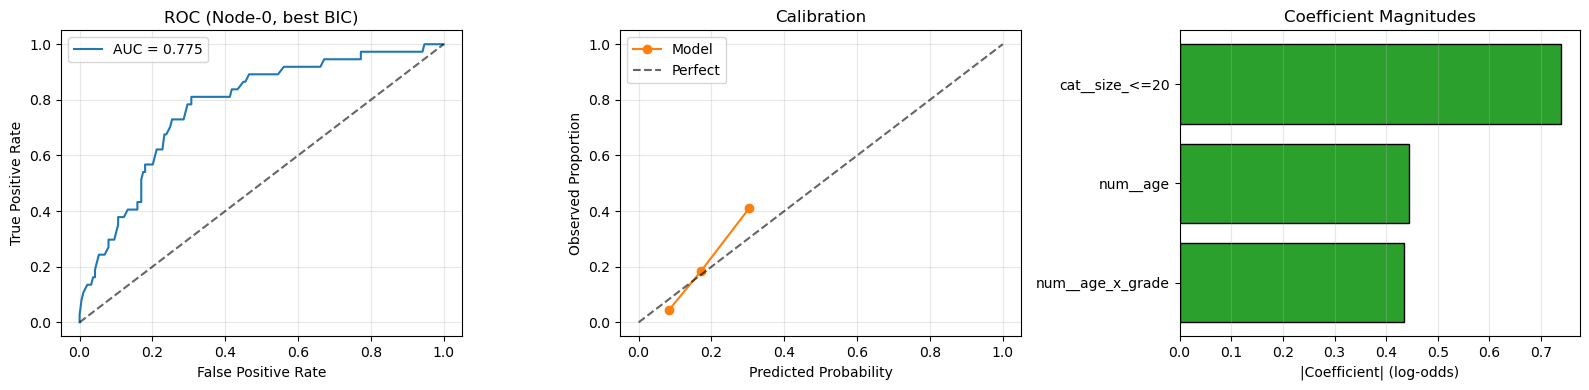

AUC: 0.775


In [31]:
# PLOT NODE-ZERO MODEL USING BEST FEATURES (from best_bic)
# Relies on variables defined in the previous cell: best_bic, X_df, y
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

best_feats = list(best_bic['features'])
print(f"Best (BIC) feature set: {best_feats}")

# Train/test split on the preprocessed, scaled matrix
X_train_plot, X_test_plot, y_train_plot, y_test_plot = train_test_split(
    X_df[best_feats], y, test_size=0.2, random_state=1234, stratify=y
)

clf_plot = LogisticRegression(solver='liblinear', max_iter=2000)
clf_plot.fit(X_train_plot, y_train_plot)

# Predictions
probs_plot = clf_plot.predict_proba(X_test_plot)[:, 1]
preds_plot = (probs_plot >= 0.5).astype(int)
auc_plot = roc_auc_score(y_test_plot, probs_plot)
fpr_plot, tpr_plot, _ = roc_curve(y_test_plot, probs_plot)
prob_true, prob_pred = calibration_curve(y_test_plot, probs_plot, n_bins=8)

# Plots: ROC, calibration, and coefficient magnitudes
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# ROC
axes[0].plot(fpr_plot, tpr_plot, label=f"AUC = {auc_plot:.3f}", color='C0')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.6)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC (Node-0, best BIC)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Calibration
axes[1].plot(prob_pred, prob_true, marker='o', color='C1', label='Model')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Perfect')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Observed Proportion')
axes[1].set_title('Calibration')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Coefficient magnitudes
coef_series = pd.Series(clf_plot.coef_[0], index=best_feats)
coef_abs = coef_series.abs().sort_values()
colors = ['tabred' if coef_series.loc[i] < 0 else 'tabblue' for i in coef_abs.index]
axes[2].barh(coef_abs.index, coef_abs.values, color='C2', edgecolor='black')
axes[2].set_title('Coefficient Magnitudes')
axes[2].set_xlabel('|Coefficient| (log-odds)')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"AUC: {auc_plot:.3f}")